# Digit Recognizer

-Learn computer vision fundamentals with the famous MNIST data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as tfs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

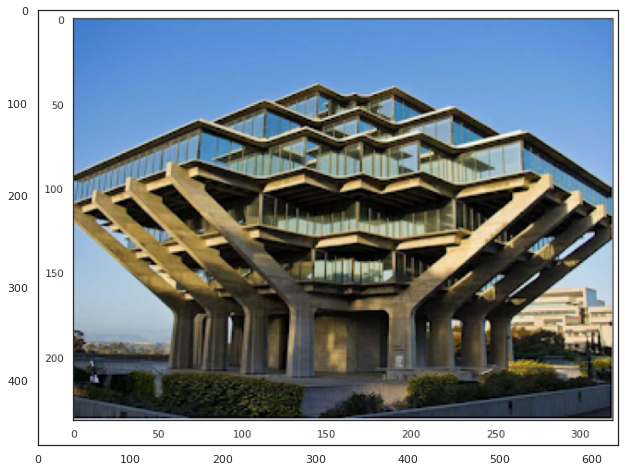

In [6]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
img = cv2.imread("/content/drive/MyDrive/KUBIG/KaggleStudy/__results___files/__results___4_0.png")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

In [7]:
kernels = dict()
kernels['Identical transformation'] = torch.tensor([[0,0,0],[0,1,0],[0,0,0]])
kernels['Selecting horizontal borders'] = torch.tensor([[0,1,0],[0,-2,0],[0,1,0]])
kernels['Selecting vertical borders'] = torch.tensor([[0,0,0],[1,-2,1],[0,0,0]])
kernels['Highlighting borders'] = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]])
kernels['Sharpening'] = torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kernels['Blur'] = torch.tensor([[0.0625,0.125,0.0625],[0.125,0.25,0.125],[0.0625,0.125,0.0625]])
kernels['Contrast'] = torch.tensor([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
kernels

{'Blur': tensor([[0.0625, 0.1250, 0.0625],
         [0.1250, 0.2500, 0.1250],
         [0.0625, 0.1250, 0.0625]]), 'Contrast': tensor([[-1, -1, -1],
         [-1,  9, -1],
         [-1, -1, -1]]), 'Highlighting borders': tensor([[ 0,  1,  0],
         [ 1, -4,  1],
         [ 0,  1,  0]]), 'Identical transformation': tensor([[0, 0, 0],
         [0, 1, 0],
         [0, 0, 0]]), 'Selecting horizontal borders': tensor([[ 0,  1,  0],
         [ 0, -2,  0],
         [ 0,  1,  0]]), 'Selecting vertical borders': tensor([[ 0,  0,  0],
         [ 1, -2,  1],
         [ 0,  0,  0]]), 'Sharpening': tensor([[ 0, -1,  0],
         [-1,  5, -1],
         [ 0, -1,  0]])}

## Creating kernels

kernel이란?

이미지의 Feauture들을 탐색하기 위해 만드는 창.
kernel 또는 filter라고 함.

manual filters


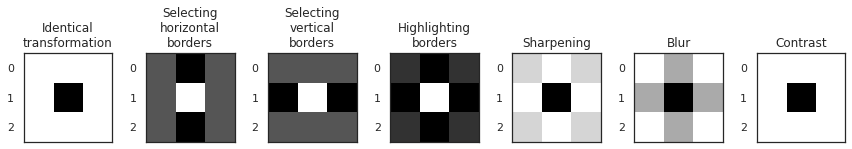

In [8]:
print('manual filters')
fig, axes = plt.subplots(1,7,figsize=(12,6))
for ax, (desc,kernel) in zip(axes.flatten(),kernels.items()) :
  ax.imshow(kernel, cmap='binary')
  ax.set_xticks([])
  ax.set_title(desc.replace(' ','\n'))
plt.tight_layout()
plt.show()

In [9]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0) # 차원 삽입
#img_t.shape : [1,471,629,3]
img_t = img_t.permute(3,0,1,2) # 차원의 순서 정렬
img_t = nn.ReflectionPad2d(1)(img_t) # img_t.shape : [3,1,471,629]

for letter,kernel in kernels.items() :
  kernel = kernel.reshape(1,1,3,3).type(torch.float32) 

  div = kernel.sum().item() #각 커널내의 값들을 모두 합한 값
  if div ==0 :
    div = 1

  result = F.conv2d(img_t,kernel) #result.shape : [3, 1, 469, 627] (471-3)/1+1=469, (629-3)/1+1 =627
  result = (result.squeeze().permute(1,2,0).numpy()/div).astype(np.int)

  plt.figure(figsize=(12,8))
  plt.imshow(result)
  plt.xlabel(letter)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## DataLoader

In [10]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 32

In [11]:
dataset_train = pd.read_csv("/content/drive/MyDrive/KUBIG/KaggleStudy/Digit_Recognizer/train.csv")
dataset_train_labels = dataset_train.label
dataset_train_images = dataset_train.drop('label',axis=1)

In [12]:
dataset = TensorDataset(
    torch.Tensor(dataset_train_images.values/255),
    torch.LongTensor(dataset_train_labels.values),
)
train, val = train_test_split(dataset, train_size=0.8)

In [13]:
dataloader_train = DataLoader(train,batch_size=BATCH_SIZE)
dataloader_valid = DataLoader(val,batch_size=BATCH_SIZE)

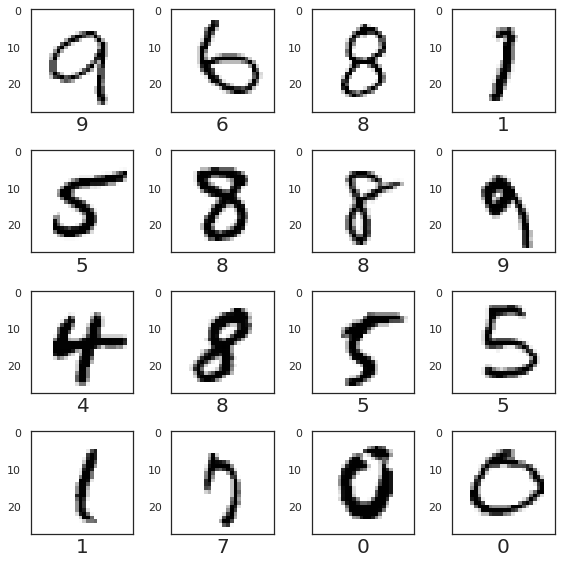

In [14]:
images, labels = next(iter(dataloader_train))
images = images.numpy().reshape(BATCH_SIZE,28,28)
fig,axes= plt.subplots(4,4,figsize=(8,8))
for ax, img, img_cls in zip(axes.flatten(),images,labels.numpy()) :
  ax.imshow(img, cmap='binary')
  ax.set_xticks([])
  ax.set_xlabel(int(img_cls),fontsize=20)
plt.tight_layout()
plt.show()

In [15]:
images.shape

(32, 28, 28)

## LeNet
Convolution Neural Network라는 개념을 최초로 개발한 Yann LeCun이 개발한 구조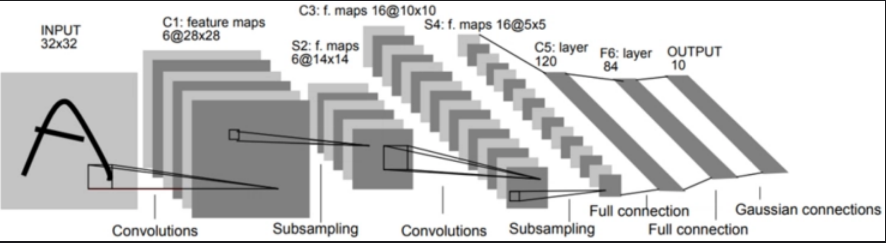

In [16]:
 class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
       
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #input : 28*28 (*32)
        x = self.pool(F.relu(self.conv1(x)))
        #(28-3)/1+1=26  -> (26-2)/2+1 = 13
        x = self.pool(F.relu(self.conv2(x)))
        #(13-3)/1+1=11 -> (11-2)/2+1 = 5
        #print(x.shape)
        x = self.flatten(x) 
        # 32*(5*5*16)=32*400
        #print(x.shape)
        x = F.relu(self.fc1(x))
        # (5*5*16)*120
        x = F.relu(self.fc2(x))
        # 120*84
        x = self.fc3(x)
        # 84*10
        return x


model = LeNet()
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [17]:
model = LeNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
loaders = {'train' : dataloader_train, 'valid': dataloader_valid}

In [18]:
loaders.items()

dict_items([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f83dd5fe1d0>), ('valid', <torch.utils.data.dataloader.DataLoader object at 0x7f83dd5fe6d0>)])

In [20]:
max_epochs = 10

losses = {"train": [], "valid": []}
accuracies = {"train": [], "valid": []}

for epoch in range(max_epochs):
    print(f"Epoch: {epoch+1}")
    for phase, dataloader in loaders.items():
        epoch_loss, epoch_correct, epoch_all = 0, 0, 0
        for images, labels in dataloader:
            images = images.reshape(images.shape[0], 1, 28, 28) # images.shape[0] = 1
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            if phase == "train":
                model.train()
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    output = model(images)
                    loss = criterion(output, labels)
            preds = output.argmax(-1)
            correct =  (preds == labels).sum()
            epoch_loss += loss.item() * BATCH_SIZE
            epoch_correct += correct.item()
            epoch_all += BATCH_SIZE
        
        print('DataLoader: {}. Loss: {}. Accuracy: {}'.format(
            phase, epoch_loss / epoch_all, epoch_correct / epoch_all
        ))
        losses[phase].append(epoch_loss / epoch_all)
        accuracies[phase].append(epoch_correct / epoch_all)

Epoch: 1
DataLoader: train. Loss: 0.13059088547492312. Accuracy: 0.9594345238095238
DataLoader: valid. Loss: 0.1013739059675669. Accuracy: 0.9660171102661597
Epoch: 2
DataLoader: train. Loss: 0.08564044836598138. Accuracy: 0.9736607142857143
DataLoader: valid. Loss: 0.09565606657167748. Accuracy: 0.9674429657794676
Epoch: 3
DataLoader: train. Loss: 0.06251740135330086. Accuracy: 0.9801488095238096
DataLoader: valid. Loss: 0.08275865846377277. Accuracy: 0.9725522813688213
Epoch: 4
DataLoader: train. Loss: 0.04872376788694445. Accuracy: 0.9843154761904762
DataLoader: valid. Loss: 0.07816036631257589. Accuracy: 0.9748098859315589
Epoch: 5
DataLoader: train. Loss: 0.03815327451414695. Accuracy: 0.9882142857142857
DataLoader: valid. Loss: 0.0782064512910825. Accuracy: 0.9755228136882129
Epoch: 6
DataLoader: train. Loss: 0.029857499136979597. Accuracy: 0.9907738095238096
DataLoader: valid. Loss: 0.07871114010635999. Accuracy: 0.9752851711026616
Epoch: 7
DataLoader: train. Loss: 0.02659222856

Text(0.5, 1.0, 'loss')

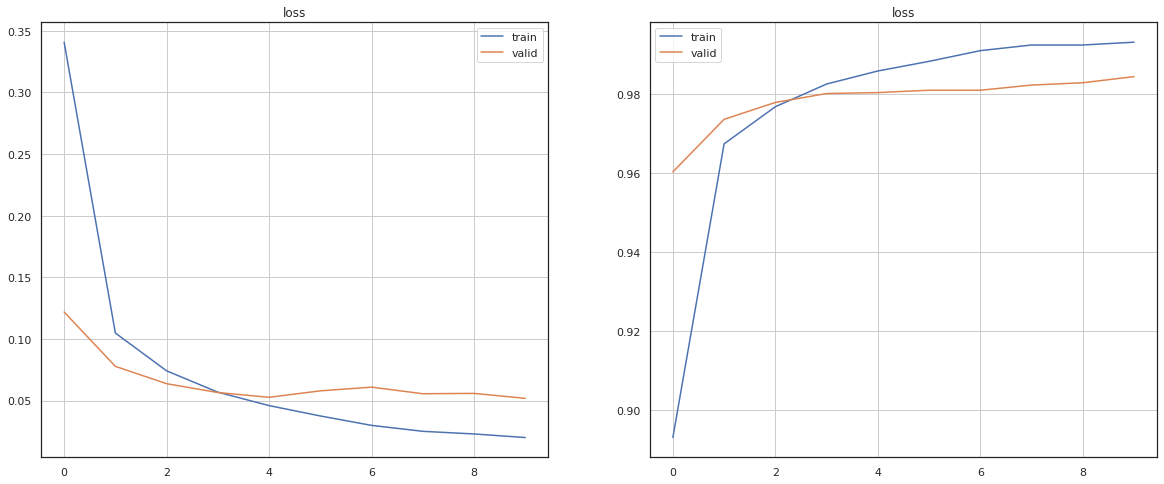

In [34]:
fig, axes = plt.subplots(1,2,figsize=(20,8))

axes[0].plot(losses['train'], label='train')
axes[0].plot(losses['valid'], label='valid')
axes[0].grid()
axes[0].legend()
axes[0].set_title('loss')

axes[1].plot(accuracies['train'], label='train')
axes[1].plot(accuracies['valid'], label='valid')
axes[1].grid()
axes[1].legend()
axes[1].set_title('loss')

In [26]:
dataset_test = pd.read_csv("/content/drive/MyDrive/KUBIG/KaggleStudy/Digit_Recognizer/test.csv")
dataloader_test = DataLoader(torch.Tensor(dataset_test.values/255),batch_size=1)

In [28]:
preds = []
model.eval()
for image in dataloader_test :
  image = image.reshape(image.shape[0],1,28,28)
  image = image.to(DEVICE)
  output = model(image)
  pred = output.argmax(-1)
  preds.append(int(pred))
print(preds)

[2, 0, 9, 9, 2, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1, 5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4, 0, 9, 2, 0, 7, 3, 0, 5, 0, 8, 0, 0, 4, 7, 1, 7, 1, 1, 3, 3, 3, 7, 2, 8, 6, 3, 8, 7, 8, 4, 3, 5, 6, 0, 0, 0, 3, 1, 3, 6, 4, 3, 4, 5, 5, 8, 7, 7, 2, 8, 4, 3, 5, 6, 5, 3, 7, 5, 7, 8, 3, 0, 4, 5, 1, 2, 7, 6, 3, 0, 2, 7, 8, 6, 1, 3, 7, 4, 1, 2, 4, 8, 5, 2, 4, 9, 2, 1, 6, 0, 6, 1, 4, 9, 6, 0, 9, 7, 6, 9, 1, 9, 0, 9, 9, 0, 8, 4, 6, 2, 0, 9, 3, 6, 3, 2, 1, 6, 3, 4, 2, 3, 1, 2, 2, 0, 4, 6, 1, 0, 0, 4, 9, 1, 7, 3, 2, 3, 8, 6, 8, 6, 2, 8, 5, 5, 4, 8, 3, 6, 9, 7, 1, 3, 8, 4, 5, 1, 4, 5, 6, 3, 3, 5, 7, 0, 6, 8, 3, 1, 6, 0, 6, 3, 9, 5, 1, 5, 8, 4, 0, 9, 2, 0, 5, 3, 7, 1, 9, 9, 5, 7, 7, 9, 9, 6, 3, 0, 3, 3, 6, 9, 8, 2, 6, 3, 7, 1, 4, 5, 8, 5, 9, 0, 0, 3, 8, 4, 1, 8, 4, 1, 1, 9, 8, 4, 5, 1, 5, 3, 6, 3, 1, 

## Visualize kernel

convolution layer 1


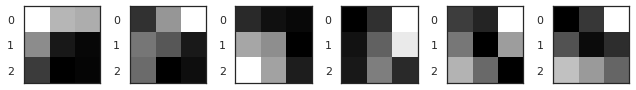

convolution layer 2


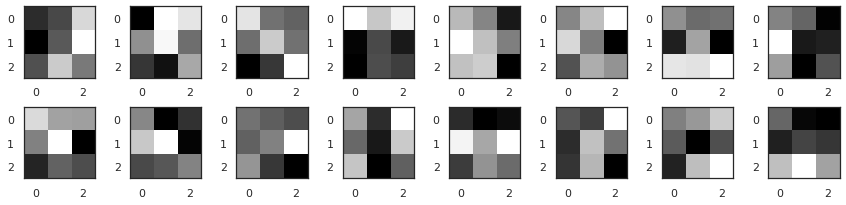

In [42]:
print('convolution layer 1')
fig,axes = plt.subplots(1,6,figsize=(9,2))
for ax, kernel in zip(axes.flatten(), model.conv1.weight) :
  ax.imshow(kernel[0,:,:].detach().cpu().numpy(),cmap='binary')
  ax.set_xticks([])
plt.tight_layout()
plt.show()

print('convolution layer 2')
fig,axes = plt.subplots(2,8, figsize=(12,3))
for ax, kernel in zip(axes.flatten(), model.conv2.weight) :
  ax.imshow(kernel[0,:,:].detach().cpu().numpy(),cmap='binary')
plt.tight_layout()
plt.show()

## Visualize Feature Maps

In [43]:
feature_map = dict()

def get_feature_map_conv1():
  def hook(model,input,output) :
    feature_map['conv1'] = output.detach()
  return hook

def get_feature_map_conv2() :
  def hook(model, input, output) :
    feature_map['conv2'] = output.detach()
  return hook

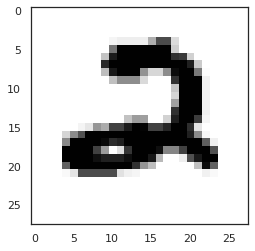

In [44]:
model.conv1.register_forward_hook(get_feature_map_conv1())
model.conv2.register_forward_hook(get_feature_map_conv2())
model.eval()
image = next(iter(dataloader_test))
image = image.reshape(image.shape[0], 1, 28, 28)
image = image.to(DEVICE)
output = model(image)

# show image

plt.imshow(image.detach().cpu().numpy().reshape(28, 28), cmap='binary')
plt.show()

In [45]:
feature_map['conv1'].shape, feature_map['conv2'].shape

(torch.Size([1, 6, 26, 26]), torch.Size([1, 16, 11, 11]))

convolution layer 1


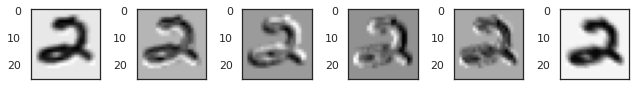

convolution layer 2


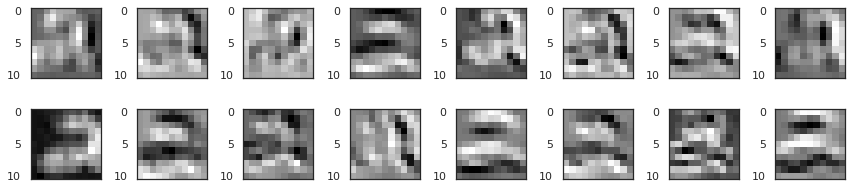

In [46]:
# look at feature maps

print('convolution layer 1')
fig, axes = plt.subplots(1, 6, figsize=(9, 2))
for ax, fmap in zip(axes.flatten(), feature_map['conv1'].squeeze()):
    ax.imshow(fmap.detach().cpu().numpy(), cmap='binary')
    ax.set_xticks([])
plt.tight_layout()
plt.show()


print('convolution layer 2')
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for ax, fmap in zip(axes.flatten(), feature_map['conv2'].squeeze()):
    ax.imshow(fmap.detach().cpu().numpy(), cmap='binary')
    ax.set_xticks([])
plt.tight_layout()
plt.show()